Largest Circle Parameters:
Center: (359.0, 283.0)
Radius: 33.31258613589958


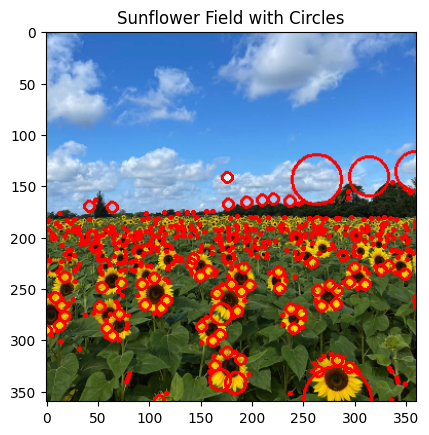

In [43]:
import cv2 as cv
from skimage.feature import blob_log
from skimage.color import rgb2gray
import numpy as np

im = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

min_sigma = 1  
max_sigma = 30  
num_sigma = 10  # Number of sigma values 
threshold = 0.15  

# Perform LoG blob detection
blobs_log = blob_log(im_gray, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)

# Compute radii in the 3rd column
blobs_log[:, 2] = blobs_log[:, 2] * np.sqrt(2)

# Find the largest circle
if len(blobs_log) > 0:
    largest_blob = blobs_log[np.argmax(blobs_log[:, 2])]
    x, y, radius = largest_blob[0], largest_blob[1], largest_blob[2]
    print("Largest Circle Parameters:")
    print(f"Center: ({x}, {y})")
    print(f"Radius: {radius}")
else:
    print("No circles detected.")

# Draw circles on the image
for blob in blobs_log:
    y, x, r = blob
    c = cv.circle(im, (int(x), int(y)), int(r), (0, 0, 255), 2)  # Draw circles in red

# Display the image 

plt.title("Sunflower Field with Circles")
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.show()


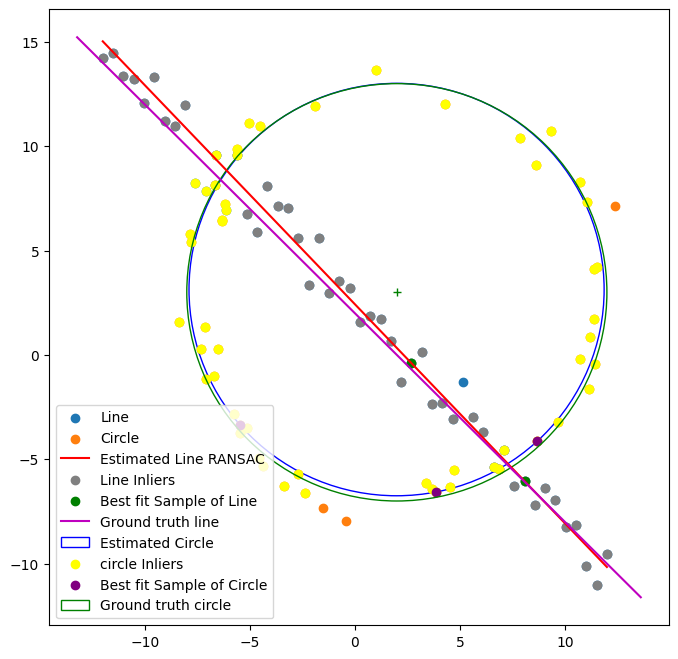

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.column_stack((x, y))

s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.column_stack((x, y))

X = np.vstack((X_circ, X_line))

def RANSAC_line(Data_set, No_of_iterations, t):
    max_inlier_count = 0
    best_fit_params = []
    best_sample_points = []

    for sample in range(0, No_of_iterations + 1):
        sample_indices = random.sample(range(len(Data_set)), 2)
        x1, x2 = Data_set[sample_indices][:, 0]
        y1, y2 = Data_set[sample_indices][:, 1]
        b = x1 - x2
        a = y2 - y1
        c = a * x1 + b * y1
        norm = np.sqrt(a ** 2 + b ** 2)
        a /= norm
        b /= norm
        c /= norm

        inlier_count = 0
        for i in range(0, len(Data_set)):
            
            distance = abs(Data_set[i][0] * a + Data_set[i][1] * b - c)
            if distance < t:
                inlier_count += 1

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            best_fit_params = (a, b, c)
            best_sample_points = Data_set[sample_indices]

    return best_fit_params, best_sample_points, max_inlier_count

def RANSAC_circle(Data_set, No_of_iterations, t):
    max_inlier_count = 0
    best_fit_params = []
    best_sample_points = []

    for sample in range(0, No_of_iterations + 1):
        
        sample_indices = random.sample(range(len(Data_set)), 3)
        x1, x2, x3 = Data_set[sample_indices][:, 0]
        y1, y2, y3 = Data_set[sample_indices][:, 1]
        P = np.array([[2 * x1, 2 * y1, 1], [2 * x2, 2 * y2, 1], [2 * x3, 2 * y3, 1]])
        if np.linalg.det(P) == 0:
            continue
        K = np.array([[x1 ** 2 + y1 ** 2], [x2 ** 2 + y2 ** 2], [x3 ** 2 + y3 ** 2]]) * (-1)
        B = np.linalg.inv(P) @ K
        g, f, c = B[0][0], B[1][0], B[2][0]
        radius = np.sqrt(g ** 2 + f ** 2 - c)

        if radius > 20:
            continue
        center = [-g, -f]
        
        inlier_count = 0
        for i in range(0, len(Data_set)):
          
            distance = abs(np.sqrt((Data_set[i][0] - center[0]) ** 2 + (Data_set[i][1] - center[1]) ** 2) - radius)
            if distance < t:
                inlier_count += 1

        if inlier_count > max_inlier_count:
            max_inlier_count = inlier_count
            best_fit_params = [g, f, c]
            best_sample_points = Data_set[sample_indices]

    return best_fit_params, best_sample_points, max_inlier_count


threshold_line = 1
No_of_iterations_line = 10000
best_line_params, best_sample_line, best_inlier_count_line = RANSAC_line(X, No_of_iterations_line, threshold_line)


# Subtract line inliers from the dataset
X_reduced = X[np.array([abs(point[0] * best_line_params[0] + point[1] * best_line_params[1] 
                            - best_line_params[2]) > threshold_line for point in X])]

threshold_circle = 1
No_of_iterations_circle = 10000
best_circle_coeff, best_sample_circle, best_inlier_count_circle = RANSAC_circle(X_reduced, No_of_iterations_circle, threshold_circle)

F, G, C = best_circle_coeff[0], best_circle_coeff[1], best_circle_coeff[2]
Radius = np.sqrt(G ** 2 + F ** 2 - C)


# Plot the data points and the estimated line and circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

x = np.linspace(-12, 12, half_n)
y = -(best_line_params[0] / best_line_params[1]) * x + (best_line_params[2] / best_line_params[1])
ax.plot(x, y, color="red", label="Estimated Line RANSAC")



# Extract the inliers for the line 
line_inliers = X[np.array([abs(point[0] * best_line_params[0] + point[1] * best_line_params[1]
                                - best_line_params[2]) <= threshold_line for point in X])]


# Plot the best-fit line (line inliers)
best_inlier_x = line_inliers[:, 0]
best_inlier_y = line_inliers[:, 1]
ax.scatter(best_inlier_x, best_inlier_y, color="gray", label="Line Inliers") 



sample_x = best_sample_line[:, 0]
sample_y = best_sample_line[:, 1]
ax.scatter(sample_x, sample_y, color="green", label="Best fit Sample of Line")


x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

circle = plt.Circle((-F, -G), Radius, fill=False, color="blue", label="Estimated Circle")
ax.add_artist(circle)

# Extract the inliers for the circle
circle_inliers = X[np.array([abs(np.sqrt((point[0]+F) ** 2 +(point[1]+G) ** 2 ) - Radius) <= threshold_circle for point in X])]


# Plot the best-fit line (circle inliers)
best_inlier_x = circle_inliers[:, 0]
best_inlier_y = circle_inliers[:, 1]
ax.scatter(best_inlier_x, best_inlier_y, color="yellow", label="circle Inliers") 


best_circle_x = best_sample_circle[:, 0]
best_circle_y = best_sample_circle[:, 1]
ax.scatter(best_circle_x, best_circle_y, color="purple", label="Best fit Sample of Circle")

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')


plt.legend()
plt.show()


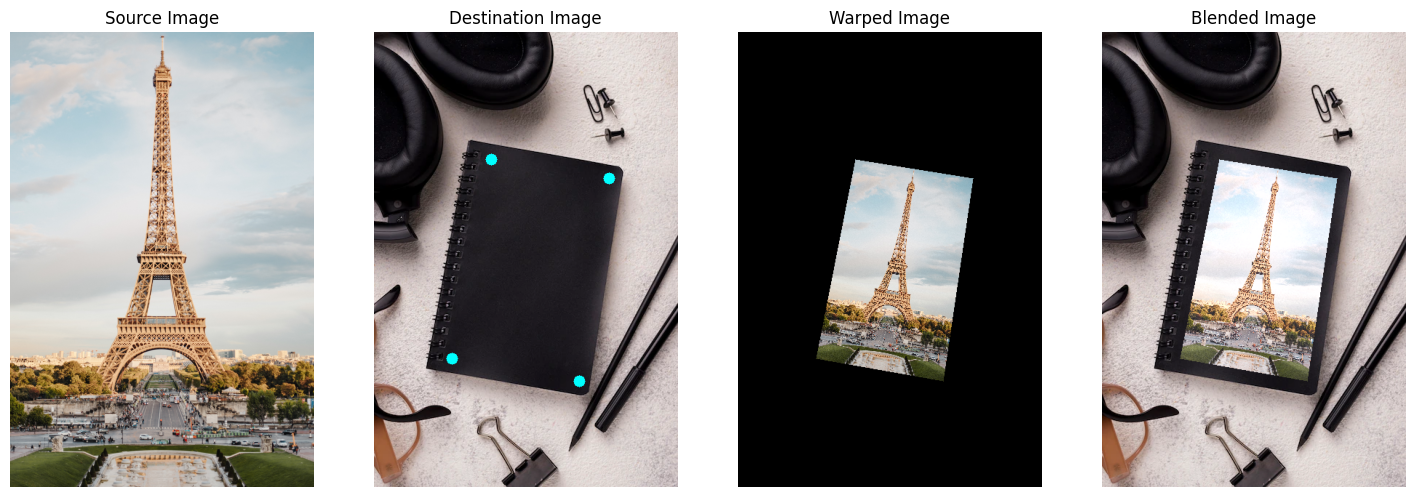

In [48]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img_dst = cv.imread('Images/book2.jpg', cv.IMREAD_COLOR)
img_src = cv.imread('images/eifel_tower.jpg', cv.IMREAD_COLOR)


def corner_points(img):
    # Returns the corner pixels of the image
    pts = []
    pts.append([0, 0])
    pts.append([img.shape[1] - 1, 0])
    pts.append([0, img.shape[0] - 1])
    pts.append([img.shape[1] - 1, img.shape[0] - 1])
    return pts

pts_src = np.array(corner_points(img_src))
pts_dst = []


def draw_circle(event, x, y, flags, param):
    # Draw a circle on the selected points on the image
    global pts_dst
    if event == cv.EVENT_LBUTTONDOWN:
        pts_dst.append((x, y))
        cv.circle(img_dst, (x, y), 8, (255, 255, 0), -1)


cv.namedWindow('image')
cv.setMouseCallback('image', draw_circle)
cv.imshow('image', img_dst)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst = np.array(pts_dst)

# Calculate Homography
if len(pts_src) >= 4 and len(pts_dst) >= 4:
    h, status = cv.findHomography(pts_src, pts_dst)
else:
    print("Not enough points to calculate homography")

# Warp source image to destination based on homography
img_warped = cv.warpPerspective(img_src, h, (img_dst.shape[1], img_dst.shape[0]))

# Blend the warped image with the destination image using the alpha value
img_blended = cv.addWeighted(img_warped, 1,cv.imread('Images/book2.jpg'),1, 0.0)


fig, ax = plt.subplots(1, 4, figsize=(18, 6))
ax[0].imshow(cv.cvtColor(img_src, cv.COLOR_BGR2RGB))
ax[0].set_title('Source Image')
ax[1].imshow(cv.cvtColor(img_dst, cv.COLOR_BGR2RGB))
ax[1].set_title('Destination Image')
ax[2].imshow(cv.cvtColor(img_warped, cv.COLOR_BGR2RGB))
ax[2].set_title('Warped Image')
ax[3].imshow(cv.cvtColor(img_blended, cv.COLOR_BGR2RGB))
ax[3].set_title('Blended Image')

# Turn off the axis for all subplots
for ax_item in ax:
    ax_item.axis('off')

plt.show()


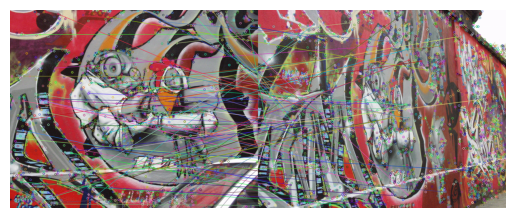

Computed Homography =  [[ 6.07784095e-01  4.74782165e-02  2.24167929e+02]
 [ 2.05730170e-01  1.12354535e+00 -1.37329863e+01]
 [ 4.63533375e-04 -6.64153246e-05  1.00000000e+00]]
Provided Homography =     6.2544644e-01   5.7759174e-02   2.2201217e+02
   2.2240536e-01   1.1652147e+00  -2.5605611e+01
   4.9212545e-04  -3.6542424e-05   1.0000000e+00



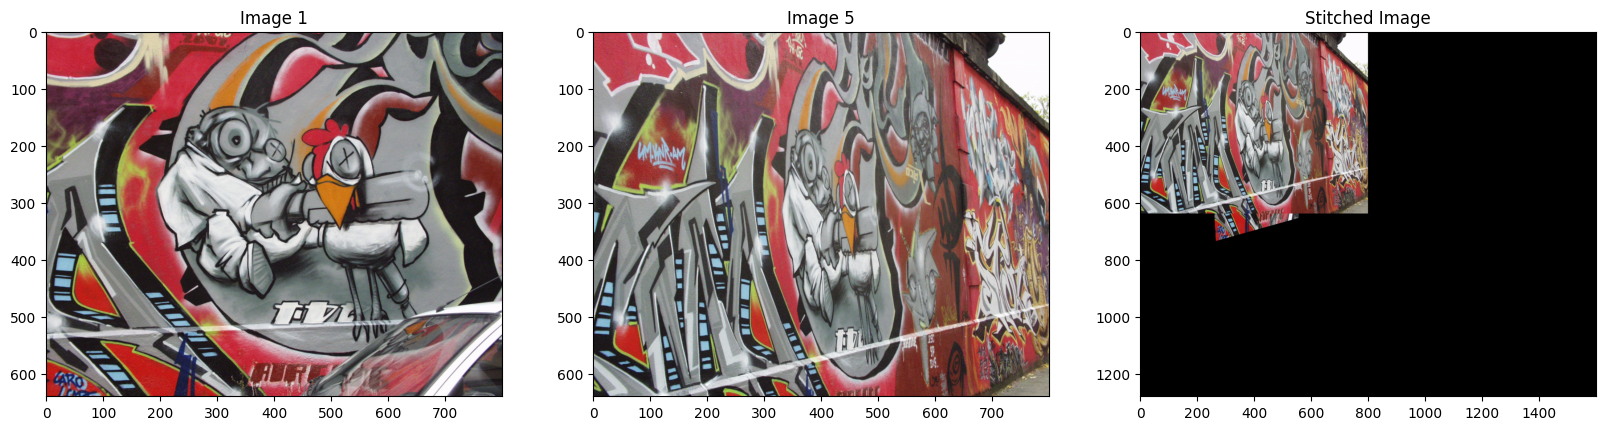

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randint

img1 = cv2.imread('images/img1.ppm')
img5 = cv2.imread('images/img5.ppm')

sift = cv2.SIFT_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints5, descriptors5 = sift.detectAndCompute(img5, None)

# Create a Brute Force Matcher
bf = cv2.BFMatcher()

# Match descriptors using K-nearest neighbor
matches = bf.knnMatch(descriptors1, descriptors5, k=2)

# Apply Lowe's ratio test to select good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

#Display the SIFT matches
matching_result = cv2.drawMatches(img1, keypoints1, img5, keypoints5, good_matches, None)

matching_result_rgb = cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB)
plt.imshow(matching_result_rgb)
plt.axis('off')
plt.show()

img2, img3, img4, img1, img5 = cv.imread("images/img2.ppm"), cv.imread("images/img3.ppm"), cv.imread("images/img4.ppm"), cv.imread("images/img1.ppm"), cv.imread("images/img5.ppm")
im1, im5, im2, im3, im4 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY), cv.cvtColor(img5, cv.COLOR_BGR2GRAY), cv.cvtColor(img2, cv.COLOR_BGR2GRAY), cv.cvtColor(img3, cv.COLOR_BGR2GRAY), cv.cvtColor(img4, cv.COLOR_BGR2GRAY)

ims = [im1, im2, im3, im4, im5]

def random_number(n, t):
    l = np.random.randint(n, size=t)
    m = np.zeros(np.shape(l))
    
    for i in range(len(l)):
        m[i] = np.sum(l==l[i])
    if np.sum(m) == len(m):
        return l
    else:
        return random_number(n,t)

def Homography(p1, p2):
    x1, y1, x2, y2, x3, y3, x4, y4 = p2[0], p2[1], p2[2], p2[3], p2[4], p2[5], p2[6], p2[7] 
    x1T, x2T, x3T, x4T = p1[0], p1[1], p1[2], p1[3]
    zero_matrix = np.array([[0], [0], [0]])

    matrix_A = np.concatenate((np.concatenate((zero_matrix.T,x1T, -y1*x1T), axis = 1), np.concatenate((x1T, zero_matrix.T, -x1*x1T), axis = 1),
                            np.concatenate((zero_matrix.T,x2T, -y2*x2T), axis = 1), np.concatenate((x2T, zero_matrix.T, -x2*x2T), axis = 1),
                            np.concatenate((zero_matrix.T,x3T, -y3*x3T), axis = 1), np.concatenate((x3T, zero_matrix.T, -x3*x3T), axis = 1),
                            np.concatenate((zero_matrix.T,x4T, -y4*x4T), axis = 1), np.concatenate((x4T, zero_matrix.T, -x4*x4T), axis = 1)), axis = 0, dtype=np.float64)
    W, v = np.linalg.eig(((matrix_A.T)@matrix_A))
    temph= v[:,np.argmin(W)]
    H = temph.reshape((3,3))
    return H

No_of_iterations=80
Hs = []
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(ims[i],None) #sifting
    key_points_2, descriptors_2 = sift.detectAndCompute(ims[i+1],None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)  #feature matching
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key = lambda x:x.distance)

    Source_Points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_Points = [key_points_2[k.trainIdx].pt for k in matches]
    threshold, best_inliers, best_H = 2, 0, 0

    for i in range(No_of_iterations):
        ran_points = random_number(len(Source_Points)-1, 4)
        f_points = []
        for j in range(4):
            f_points.append(np.array([[Source_Points[ran_points[j]][0], Source_Points[ran_points[j]][1], 1]]))

        t_points = []
        for j in range(4):
            t_points.append(Destination_Points[ran_points[j]][0]) 
            t_points.append(Destination_Points[ran_points[j]][1])

        H = Homography(f_points,t_points)
        
        inliers = 0 
        for k in range(len(Source_Points)):
            X = [Source_Points[k][0], Source_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            error = np.sqrt(np.power(HX[0]-Destination_Points[k][0], 2) + np.power(HX[1]-Destination_Points[k][1], 2))
            if error < threshold:
                inliers +=1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H 
    Hs.append(best_H)
    
H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]

print("Computed Homography = ", H1_H5)
print("Provided Homography = ", open("images/H1to5p",'r').read())

result = cv.warpPerspective(img1, H1_H5, (im1.shape[1] + im5.shape[1],im1.shape[0] + im5.shape[0]))
result[0:im5.shape[0], 0:im5.shape[1]] = img5

fig, ax = plt.subplots(1,3,figsize=(20,20))
ax[0].imshow(cv.cvtColor(img1,cv.COLOR_BGR2RGB)), ax[0].set_title("Image 1")
ax[1].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB)), ax[1].set_title("Image 5")
ax[2].imshow(cv.cvtColor(result,cv.COLOR_BGR2RGB)), ax[2].set_title("Stitched Image")
plt.show()



